In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import h5py
from pathlib import Path    
import seaborn as sns
from collections.abc import Iterable

In [6]:
datapath = Path.cwd() / "results/short_times"

In [3]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2)
    else:
        return np.std(A[:,:,0:n_samples],2)

In [4]:
def modified_disorder_mean(arr,distance_matrix):
    N = arr.shape[1]
    SHOTS = arr.shape[2]
    n_bins = int(np.max(distance_matrix))+1 #Bins [0,1),[1,2),...
    new_arr = np.zeros((arr.shape[0],n_bins))
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot])
            new_arr[:,j_eff] += arr[:,j,shot]
            counts[j_eff] += 1
    for bin in range(0,n_bins):
        if counts[bin] != 0:
            new_arr[:,bin] = new_arr[:,bin]/counts[bin]
    return new_arr

def count_bins(distance_matrix):
    N = distance_matrix.shape[0]
    SHOTS = distance_matrix.shape[2]
    n_bins = int(np.max(distance_matrix))+1 #Bins [0,1),[1,2),...
    counts = np.zeros(n_bins)
    for shot in range(0,SHOTS):
        for j in range(0,N):
            j_eff= int(distance_matrix[0,j,shot])
            counts[j_eff] += 1
    return counts

In [17]:
jobids = []
params = []
data = []
positiondesc = []
positions = []
distance_matrices = []
N = 13
files = ["_N13_rp_z.jld2","_N13_rp.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(datapath/file,"r") as f:
        data.append(2-2*rearrange_data(f["data"][()]))
        params.append(f["params"][()])
        positiondesc.append(f["positiondata"][()][0]) #Fix spelling in future runs!
        positions.append(np.swapaxes(f[f["positiondata"][()][1]],0,1))
        distance_matrices.append(np.swapaxes(f[f["positiondata"][()][2]],0,2))
T = np.arange(0,2.1,0.01)
xcenter = 1
SHOTS = 100

In [18]:
data[0].shape

(201, 13, 100)

In [19]:
#res = list(map(lambda arr: symmetrize(disorder_mean(arr)),data))
#res_err = list(map(lambda arr: symmetrize(disorder_std(arr)),data))
res = list(map(lambda arr: disorder_mean(arr),data))
res_err = list(map(lambda arr: disorder_std(arr),data))

In [20]:
res_m = list(map(lambda arr,distance_matrix: modified_disorder_mean(arr,distance_matrix), data, distance_matrices))
counts = list(map(lambda distance_matrix: count_bins(distance_matrix),distance_matrices))

IndexError: Replacement index 1 out of range for positional args tuple

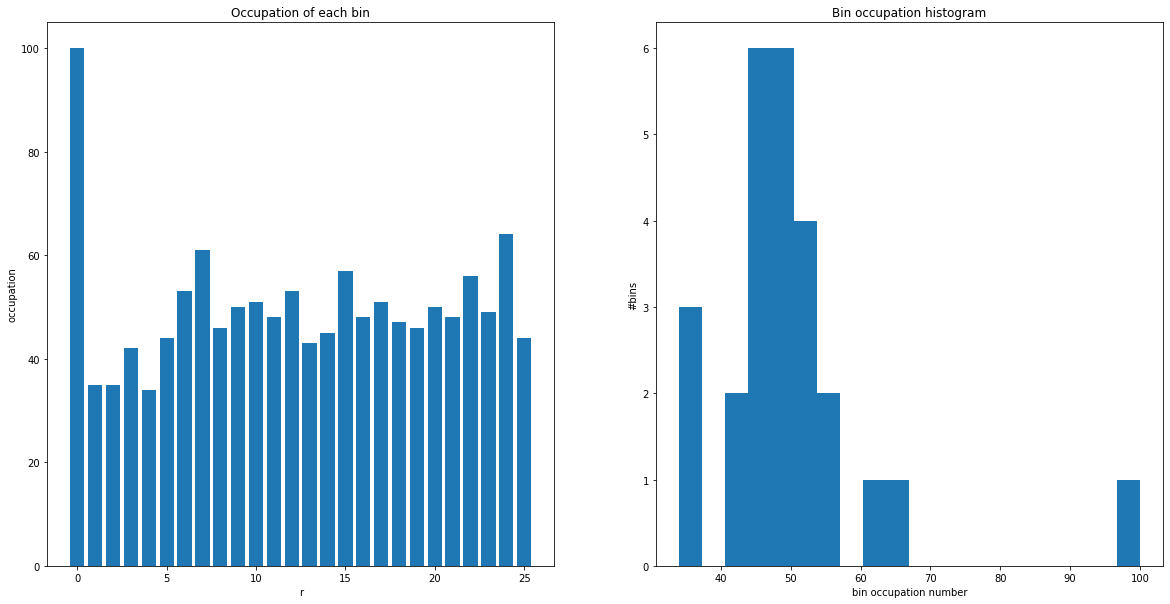

In [23]:
ds=0
bins = [i for i in range(0,len(counts[ds]))]
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[1].hist(counts[ds],20)
axs[1].set_title("Bin occupation histogram")
axs[1].set_xlabel("bin occupation number")
axs[1].set_ylabel("#bins")

axs[0].bar(bins,counts[ds])
axs[0].set_title("Occupation of each bin")
axs[0].set_xlabel("r")
axs[0].set_ylabel("occupation")
plt.suptitle(r"Binning disordered distances, geometry:{}, $\rho=${}".format(positiondesc[ds][0][-1]))
plt.show()
